<a href="https://colab.research.google.com/github/shpotes/traffic-counter/blob/master/notebooks/loss-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install Faster R-CNN

In [1]:
!git clone https://github.com/shpotes/traffic-counter
%cd traffic-counter/notebooks

Cloning into 'traffic-counter'...
remote: Enumerating objects: 905, done.
^Cceiving objects:  18% (163/905), 4.29 MiB | 1.20 MiB/s      
[Errno 2] No such file or directory: 'traffic-counter/notebooks'
/home/santiago/Projects/object-detection/notebooks


#◢ Setup

In [2]:
!pip install -r ../requirements.txt

     |████████████████████████████████| 86.3MB 208kB/s 
     |████████████████████████████████| 26.6MB 58.5MB/s 
     |████████████████████████████████| 501kB 52.6MB/s 
     |████████████████████████████████| 4.3MB 41.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20


In [1]:
import sys
import os
import json
from itertools import groupby
from operator import itemgetter
from typing import List, Tuple, Dict

import gin
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

sys.path.append('..')

from vehicle_nowcasting.data.data_loader import *
from vehicle_nowcasting.data.generate_anchors import generate_anchors as gen_anch
from vehicle_nowcasting.utils import iou, plot_bb, change_box_order, compute_stride_from_receptive_field

%matplotlib inline

##◢ Load metadata

In [2]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/label_map.json', 'r'))

In [3]:
sources = build_source_from_metadata(metadata,
                                     label_map,
                                     data_dir)

In [4]:
sources[:2]

[('../data/train/15-02-15-20:17.jpg',
  [(1, 225, 117, 411, 281),
   (3, 335, 212, 456, 329),
   (3, 555, 140, 607, 210),
   (4, 470, 211, 553, 307),
   (4, 442, 138, 519, 202),
   (4, 24, 238, 147, 334),
   (4, 166, 176, 244, 258),
   (4, 388, 110, 435, 167),
   (4, 505, 96, 557, 149),
   (1, 436, 39, 528, 126),
   (3, 546, 66, 593, 106),
   (3, 615, 59, 663, 99)]),
 ('../data/train/33.09-14-17:43.jpg',
  [(3, 378, 288, 579, 474),
   (3, 271, 7, 346, 58),
   (3, 558, 191, 704, 307),
   (3, 555, 132, 695, 214),
   (3, 405, 65, 498, 126),
   (3, 302, 75, 393, 135),
   (3, 227, 32, 293, 72),
   (3, 213, 1, 268, 26),
   (3, 71, 16, 120, 58),
   (2, 8, 39, 101, 155),
   (5, 83, 57, 109, 96),
   (5, 148, 143, 187, 203),
   (5, 150, 108, 191, 161),
   (5, 349, 373, 443, 477),
   (5, 310, 437, 384, 480)])]

In [5]:
ds = make_dataset(sources, mode=None)

W0917 13:04:45.425633 139787959691072 deprecation.py:323] From /home/santiago/anaconda3/envs/CV/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1486: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#◢ Let's try a simple example

W0917 13:04:48.171235 139787959691072 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


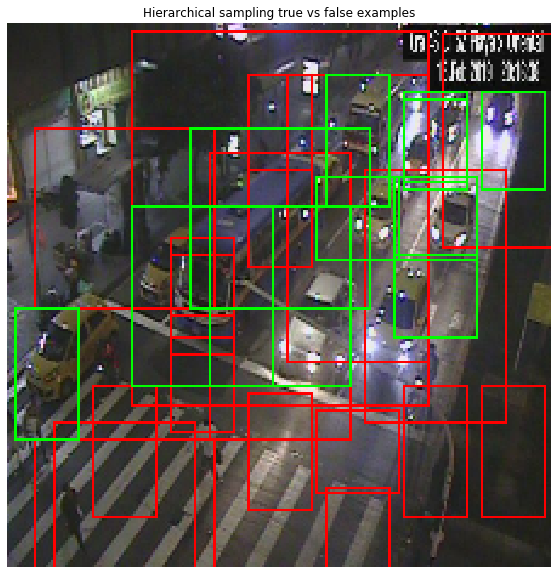

In [6]:
tensor = next(iter(ds))
anchors = tensor[1].numpy()
img = tensor[0].numpy()[:, :]

neg = anchors[anchors[:, 0] == -1]
pos = anchors[anchors[:, 0] != -1]

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Hierarchical sampling true vs false examples');

In [7]:
tensor = next(iter(ds))
_, anchor_bbox, ground_truth = tensor
anchor_bbox.shape, ground_truth.shape

(TensorShape([32, 5]), TensorShape([12, 5]))

![](res/faster-rcnn.png)

In [8]:
def RPN(conv_feature_map, k):
    conv_feature_map = ZeroPadding2D(1)(conv_feature_map)
    sliding_window = Conv2D(256, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='window')(conv_feature_map)
    cls_layer = Conv2D(2 * k,
                       kernel_size=(1, 1),
                       activation='sigmoid',
                       name='cls_head')(sliding_window)
    reg_layer = Conv2D(4 * k,
                       kernel_size=(1, 1),
                       name='reg_head')(sliding_window)
    
    return [cls_layer, reg_layer]

In [9]:
inputs = Input(shape=(224, 224, 3))
backbone_model = VGG16(input_tensor=inputs,
                       weights='imagenet',
                       include_top=False)

backbone_model.summary()
# Expected RPN output size?

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
k = len(gen_anch())

x = backbone_model.output
model = Model(inputs=inputs, outputs=RPN(x, k))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [11]:
conv_move = tf.constant(compute_stride_from_receptive_field(), dtype=tf.int32)
conv_move

<tf.Tensor: id=938, shape=(7,), dtype=int32, numpy=array([ 16,  48,  80, 112, 144, 176, 208], dtype=int32)>

In [12]:
anchors = tf.constant(gen_anch(), tf.int32)

grid_size = len(conv_move)
k = len(anchors)

dx = conv_move
dy = conv_move

In [13]:
anchors

<tf.Tensor: id=939, shape=(15, 4), dtype=int32, numpy=
array([[ -17,  -17,   17,   17],
       [ -37,  -37,   37,   37],
       [ -77,  -77,   77,   77],
       [ -13,  -17,   13,   17],
       [ -29,  -37,   29,   37],
       [ -61,  -77,   61,   77],
       [ -13,  -20,   13,   20],
       [ -29,  -44,   29,   44],
       [ -61,  -92,   61,   92],
       [ -13,  -24,   13,   24],
       [ -29,  -52,   29,   52],
       [ -61, -108,   61,  108],
       [ -13,  -27,   13,   27],
       [ -29,  -59,   29,   59],
       [ -61, -123,   61,  123]], dtype=int32)>

In [14]:
dy = tf.reshape(dy, (-1, 1, 1))
dx = tf.reshape(dx, (1, -1, 1))

dx = tf.concat([dx, tf.zeros((1, grid_size, 1), dtype=tf.int32)], axis=-1)
dy = tf.concat([tf.zeros((grid_size, 1, 1), dtype=tf.int32), dy], axis=-1)

reference = tf.reshape(dx + dy, (1, grid_size, grid_size, 1, 2))
reference = tf.concat([reference, reference], axis=-1)

anchors = reference + tf.reshape(anchors, (1, 1, 1, k, 4))
anchors = tf.transpose(anchors, [0, 2, 1, 3, 4])

In [15]:
print(anchors[0, 0, 0, 0])
print(anchors[0, 1, 0, 0])
print(anchors[0, 0, 1, 0])

tf.Tensor([-1 -1 33 33], shape=(4,), dtype=int32)
tf.Tensor([31 -1 65 33], shape=(4,), dtype=int32)
tf.Tensor([-1 31 33 65], shape=(4,), dtype=int32)


In [16]:
cond = tf.equal(tf.reshape(anchor_bbox[:, 1:], (-1, 1, 1, 1, 4)), anchors)
cond = tf.reduce_all(cond, axis=-1)
anchor_map = tf.cast(tf.where(cond), tf.int32)

anchor_map[:3]
# index, dx, dy, anchor_index

<tf.Tensor: id=990, shape=(3, 4), dtype=int32, numpy=
array([[0, 3, 5, 8],
       [1, 3, 3, 4],
       [2, 6, 2, 3]], dtype=int32)>

In [17]:
gt_pointer = anchor_bbox[:, :1] # get GT index
p_raw = tf.cast(gt_pointer != -1, tf.int32) # 1 for positive examples, 0 for negative example

In [18]:
# anchor_index * 2 if negative example
# anchor_index * 2 + 1 if positive example
p_loc_raw = tf.cast(anchor_map[:, -1:] * 2, tf.int32) + p_raw # Choose position on matrix 
p_loc = tf.concat([anchor_map[:, 1:-1], p_loc_raw], axis=-1) # add x & y coordinates
p_loc[:3]
# x_index, y_index, anchor_index

<tf.Tensor: id=1014, shape=(3, 3), dtype=int32, numpy=
array([[ 3,  5, 16],
       [ 3,  3,  9],
       [ 6,  2,  6]], dtype=int32)>

In [19]:
p_template = np.zeros((7, 7, 2 * k))
p = tf.tensor_scatter_nd_update(p_template, p_loc, tf.ones(32)) ####### HERE

In [20]:
ext_ground_truth = tf.concat([[[-1, 1, 2, 3, 4]], ground_truth], axis=0) # fill GT
_gt = tf.gather(ext_ground_truth, gt_pointer[:, 0] + 1)[:, 1:] # get GT for each index
# a simple hack, we have zero-based index on `gt_pointer` with -1 for negative examples, 
# by adding 1 we can remap indices 

_gt = change_box_order(tf.cast(_gt, tf.float64))
_bb = change_box_order(tf.cast(anchor_bbox[:, 1:], tf.float64))

$$
\begin{align*}
t_x &= (x - x_a) / w_a, & t_y &= (y - y_a) / h_a, \\
t_w &= \log{(w / w_a)}, & t_h &= \log{(h / h_a)}, \\
t_x^* &= (x^* - x_a) / w_a, & t_y^* &= (y^* - y_a) / h_a, \\
t_w^* &= \log{(w^* / w_a)}, & t_h^* &= \log{(h^* / h_a)}, \\
\end{align*}
$$

where $x, y, w,$ and $h$ denote the box’s center coordinates and its width and height. Variables $x, x_a,$ and $x^∗$ are for the predicted box, anchor box, and groundtruth box respectively

In [67]:
t_loc = tf.cast(anchor_map[:, 1:], tf.int32) # Raw locations
t_template = np.zeros((7, 7, k, 4)) 

_t = tf.tensor_scatter_nd_update(t_template, t_loc, _gt) # this 
t_a = tf.tensor_scatter_nd_update(t_new, t_loc, _bb) # this

## Part of the reg loss 

t_xy = _t[:, :, :, :2]
t_wh = _t[:, :, :, -2:]
t_a_xy = t_a[:, :, :, :2]
t_a_wh = t_a[:, :, :, -2:]

t_xy = (t_xy - t_a_xy) / t_wh
t_wh = tf.math.log(t_wh / t_a_wh)

t_xy = tf.reshape(t_xy, (7, 7, -1))
t_wh = tf.reshape(t_wh, (7, 7, -1))

t = tf.concat([t_xy, t_wh], axis=-1)

t = tf.where(tf.math.is_nan(t),
             tf.zeros_like(t),
             t)